In [312]:
!pip install qiskit_ibm_provider

DEPRECATION: qiskit-nature 0.5.1 has a non-standard dependency specifier qiskit-terra>=0.22.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of qiskit-nature or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [37]:
import numpy as np
import pandas as pd
import math
import random
import re

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Import required for random matrix generation
import scipy.stats as stats
import scipy.sparse as sparse
from docplex.cp.utils_visu import display

from qiskit import *

# QP specific imports
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo, LinearInequalityToPenalty

# QAOA and circuit cutting specific imports
from qiskit.circuit.library import QAOAAnsatz
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_37275/351962786.py:24: DeprecationWarning: The package namespace circuit_knitting_toolbox is deprecated and will be removed no sooner than Circuit Knitting Toolbox 0.4.0. Use namespace circuit_knitting instead.
  from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires
/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_37275/351962786.py:24: DeprecationWarning: The package namespace circuit_knitting_toolbox.circuit_cutting is deprecated and will be removed no sooner than Circuit Knitting Toolbox 0.4.0. Use namespace circuit_knitting.cutting instead.
  from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires


In [38]:
import random
import seaborn as sns

# Import required for random matrix generation
import scipy.stats as stats
import scipy.sparse as sparse
from docplex.cp.utils_visu import display

from qiskit import *

In [39]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler
from qiskit.circuit import Parameter

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from circuit_knitting.cutting.instructions import CutWire, Move
from circuit_knitting.cutting import cut_wires, expand_observables

In [40]:
import string
labels = string.ascii_uppercase + string.ascii_lowercase   #string.ascii_letters#
from collections import OrderedDict

from matplotlib import pylab as pl

from sklearn.cluster import SpectralClustering
from sklearn import metrics
import markov_clustering as mc

In [41]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp 
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [42]:
def sprandsym(n, density,seed):
    np.random.seed((seed))
    rvs = stats.poisson(25, loc=10).rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

def binarize_sparse_matrix(sparse_matrix):
    # create a copy of the sparse matrix to keep the operation non-destructive
    sparse_copy = sparse_matrix.copy()
    #sparse_copy=sparse_copy-sparse.diags(sparse_copy.diagonal())
    # find the coordinates of non-zero elements
    non_zero_coords = sparse_copy.nonzero()
    # set those elements to 1
    sparse_copy[non_zero_coords] = 1
    return sparse_copy

def generate_graph_from_matrix(binarized_sparse_mat):
    G = nx.from_scipy_sparse_array(binarized_sparse_mat)
    return G


# create the quadratic program instance and define the variables
def create_qp_from_qmatrix(Q_matrix):
    max_keys = Q_matrix.shape[0]
    qp = QuadraticProgram('QUBO Matrix Optimization')
    x = qp.binary_var_list(name='x', keys=range(1, max_keys + 1))

    linear_vars = {qp.get_variable(i).name: Q_matrix[i, j]
                   for i in range(max_keys) for j in range(max_keys) if i == j}
    quadratic_vars = {(qp.get_variable(i).name, qp.get_variable(j).name): Q_matrix[i, j]
                      for i in range(max_keys) for j in range(max_keys) if i != j}

    qp.minimize(linear=linear_vars, quadratic=quadratic_vars)
    return qp
    #print(self.qp.prettyprint())


def create_qaoa_ansatz(qp):
    #self.create_qp_from_qmatrix()
    h_qubo, offset = qp.to_ising()
    #print(h_qubo)
    qaoa_ansatz = QAOAAnsatz(cost_operator=h_qubo, reps=1, )
    qaoa_ansatz.entanglement = 'linear'
    params = len(qaoa_ansatz.parameters)
    theta_range = np.linspace(0, np.pi, params)
    qaoa_qc = qaoa_ansatz.bind_parameters(theta_range)
    decomposed_qaoa_ansatz = qaoa_qc.decompose().decompose().decompose().decompose()
    return h_qubo, offset,decomposed_qaoa_ansatz


In [43]:
def get_subgraph_properties1(G):
    cnt=0
    subgraphs = (G.subgraph(c) for c in nx.connected_components(G))
    subgraph_prop = {}
    prop = []
    max_size = []
    max_subgraph_nodes = ''
    for s in subgraphs:
        #print(s.nodes())
        n = tuple(s.nodes())
        subgraph_prop[n] = nx.adjacency_matrix(s).todense()
        #print(s.size())
        #print(f'Subgraph {cnt}:: Num of Edges: {s.size()},  Nodes : {s.nodes()}  ')
        cnt+=1
        max_size.append(len(s.nodes()))
        if len(s.nodes)== np.max(max_size):
            max_subgraph_nodes = s.nodes()
        
        
    #print(max_subgraph_nodes)
    return cnt, np.max(max_size), subgraph_prop, max_subgraph_nodes



In [136]:
matrix_sizes =  [10] 
matrix_densities = [0.1]#,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 1
random_seeds = [random.randint(300, 1000) for _ in range(num_of_experiments)]
max_cluster_sizes = [3]#,5,7]

n=matrix_sizes[0]
p=matrix_densities[0]
seed = [random.randint(300, 1000) for _ in range(num_of_experiments)][0]

max_cluster_size = 3

In [137]:
M=sprandsym(n,p,101)
M=binarize_sparse_matrix(M)
q=generate_graph_from_matrix(M)
qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)


{(1, 2): Text(-0.7308866016482138, -0.12296066395106253, '1.0'),
 (1, 4): Text(-0.6350686410573421, -0.00780604936891998, '1.0'),
 (1, 5): Text(-0.6220116840781471, -0.16478395524548833, '1.0'),
 (3, 4): Text(-0.6170289853443336, 0.1555932360450793, '1.0'),
 (7, 9): Text(0.8981613721464801, 0.3427287875673802, '1.0')}

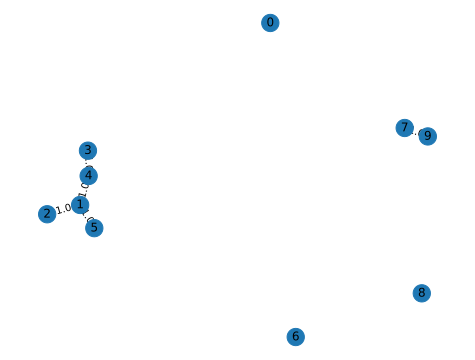

In [138]:
#plt.figure(figsize=(4,4))
pos = nx.spring_layout(q, seed=3113794652)
edge_labels = nx.get_edge_attributes(q, "weight")
nx.draw(q,pos, with_labels=True )
nx.draw_networkx_edge_labels(q, pos=pos, edge_labels=edge_labels)


In [139]:
data = qsubgraph_prop[tuple(max_subgraph_nodes)]
q1=nx.from_numpy_array(data)
node_lbl = dict(zip(list(q1.nodes), list(max_subgraph_nodes)))
nx.set_node_attributes(q1, values=node_lbl, name='labels')

In [140]:
max_subgraph_size = len(max_subgraph_nodes)

In [141]:
n_clusters = int(np.ceil(max_subgraph_size/max_cluster_size))
n_clusters

2

In [142]:
data = np.array(data)
data

array([[0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [143]:
n_qubits = max_cluster_size
size = max_subgraph_size
qp = create_qp_from_qmatrix(data)
print(qp)
h_qubit, offset, qaoa = create_qaoa_ansatz(qp)

minimize 2*x1*x2 + 2*x1*x4 + 2*x1*x5 + 2*x3*x4 (5 variables, 0 constraints, 'QUBO Matrix Optimization')


In [191]:
h_qubit

PauliSumOp(SparsePauliOp(['IIIZZ', 'IIIIZ', 'IIIZI', 'IZIIZ', 'IZIII', 'IZZII', 'IIZII', 'ZIIIZ', 'ZIIII'],
              coeffs=[ 0.5+0.j, -1.5+0.j, -0.5+0.j,  0.5+0.j, -1. +0.j,  0.5+0.j, -0.5+0.j,
  0.5+0.j, -0.5+0.j]), coeff=1.0)

In [144]:
qaoa_observable_pat = '[A-Z]+'
observables = PauliList(re.findall(qaoa_observable_pat, str(h_qubit)))
observables

PauliList(['IIIZZ', 'IIIIZ', 'IIIZI', 'IZIIZ', 'IZIII', 'IZZII', 'IIZII',
           'ZIIIZ', 'ZIIII'])

{(0, 1): Text(0.654508476093664, 0.47552828417802706, '1.0'),
 (0, 3): Text(0.09549150155459352, -0.2938926605550248, '1.0'),
 (0, 4): Text(0.6545085505994722, -0.4755282543757038, '1.0'),
 (2, 3): Text(-0.8090170266931362, -2.980232327587373e-08, '1.0')}

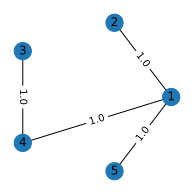

In [145]:
plt.figure(figsize=(2.5,2.5))
pos = nx.circular_layout(q1)
edge_labels = nx.get_edge_attributes(q1, "weight")

nx.draw(q1, with_labels=True, labels=node_lbl, pos=pos)
nx.draw_networkx_edge_labels(q1, pos=pos, edge_labels=edge_labels)

In [146]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 2.0
Ising Hamiltonian:
0.5 * IIIZZ
- 1.5 * IIIIZ
- 0.5 * IIIZI
+ 0.5 * IZIIZ
- 1.0 * IZIII
+ 0.5 * IZZII
- 0.5 * IIZII
+ 0.5 * ZIIIZ
- 0.5 * ZIIII


In [147]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())



objective function value: 0.0
variable values: x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0
status: SUCCESS


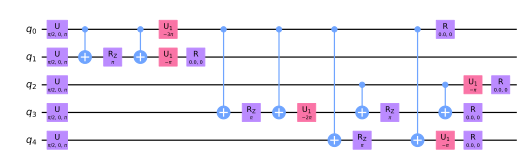

In [54]:
qaoa.draw(scale=0.6)

In [55]:
num_subcircuits = math.ceil(size/n_qubits)
num_subcircuits

2

In [56]:
cuts = cut_circuit_wires(
                        circuit=qaoa,
                        method="automatic",
                        max_subcircuit_width=n_qubits,
                        max_cuts= num_subcircuits+1,
                        num_subcircuits=[3]
                    )

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 3 times.
MIP Presolve eliminated 96 rows and 26 columns.
MIP Presolve modified 24 coefficients.
Aggregator did 78 substitutions.
Reduced MIP has 248 rows, 100 columns, and 734 nonzeros.
Reduced MIP has 91 binaries, 9 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.20 ticks)
Found incumbent of value 2.000000 after 0.01 sec. (2.93 ticks)
Probing fixed 23 vars, tightened 0 bounds.
Probing changed sense of 9 constraints.
Probing time = 0.00 sec. (0.58 ticks)
Cover probing fixed 2 vars, tightened 7 bounds.
Tried aggregator 4 times.
MIP Presolve eliminated 113 rows and 45 columns.
MIP Presolve modified 22 coefficients.
Aggregator did 12 substitutions.
Reduced MIP has 123 rows, 43 columns, and 363 nonzeros.
Reduc

In [57]:
cuts.keys()

dict_keys(['max_subcircuit_width', 'subcircuits', 'complete_path_map', 'num_cuts', 'counter', 'classical_cost'])

In [67]:
cuts['subcircuits'][0]

In [58]:
print(cuts['complete_path_map'])

{Qubit(QuantumRegister(5, 'q'), 0): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}], Qubit(QuantumRegister(5, 'q'), 1): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}], Qubit(QuantumRegister(5, 'q'), 2): [{'subcircuit_idx': 2, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}], Qubit(QuantumRegister(5, 'q'), 3): [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 1)}, {'subcircuit_idx': 2, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}], Qubit(QuantumRegister(5, 'q'), 4): [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 2)}]}


#### find the a_subs automatically based cuts.complete_path_map

In [69]:
for sc in cuts['subcircuits']:
    print(sc)

     ┌────────────┐                   ┌─────────┐            
q_0: ┤ U(π/2,0,π) ├──■─────────────■──┤ U1(-3π) ├────────────
     ├────────────┤┌─┴─┐┌───────┐┌─┴─┐└┬────────┤┌──────────┐
q_1: ┤ U(π/2,0,π) ├┤ X ├┤ Rz(π) ├┤ X ├─┤ U1(-π) ├┤ R(0.0,0) ├
     └────────────┘└───┘└───────┘└───┘ └────────┘└──────────┘
                                                                    »
q_0: ────────────────■─────────────■───────────────■─────────────■──»
     ┌────────────┐┌─┴─┐┌───────┐┌─┴─┐┌─────────┐  │             │  »
q_1: ┤ U(π/2,0,π) ├┤ X ├┤ Rz(π) ├┤ X ├┤ U1(-2π) ├──┼─────────────┼──»
     ├────────────┤└───┘└───────┘└───┘└─────────┘┌─┴─┐┌───────┐┌─┴─┐»
q_2: ┤ U(π/2,0,π) ├──────────────────────────────┤ X ├┤ Rz(π) ├┤ X ├»
     └────────────┘                              └───┘└───────┘└───┘»
«     ┌──────────┐            
«q_0: ┤ R(0.0,0) ├────────────
«     └──────────┘            
«q_1: ────────────────────────
«      ┌────────┐ ┌──────────┐
«q_2: ─┤ U1(-π) ├─┤ R(0.0,0) ├
«      └──────

In [88]:
qubit_sc_idx = {}
sc_idx = []
for scbit, scidx_arr in cuts['complete_path_map'].items():
    k = qaoa.find_bit(bit=scbit)[0]
    #k = scbit.index  # being deprecated
    qubit_sc_idx.setdefault(k,[])
    for scidx in range(len(scidx_arr)):
        sci = scidx_arr[scidx]['subcircuit_idx']
        qubit_sc_idx[k].append(sci)
        if sci not in sc_idx:
            sc_idx.append(sci)
        
print(qubit_sc_idx) # qubit : subcircuit mapping
print(sc_idx)  # array of unique subcircuit indices

{0: [0, 1], 1: [0], 2: [2], 3: [1, 2], 4: [1]}
[0, 1, 2]


In [75]:
qubit_sc_idx  

#-- q0 is part of subcircuit 0 and 1 -> we need a cut on q0 after subcircuit0
#-- q3 is part of subcircuit 1 and 2 -> we need a cut on q3 after subcircuit1

{0: [0, 1], 1: [0], 2: [2], 3: [1, 2], 4: [1]}

In [109]:
sc_qubit_idx

{0: [0, 1], 1: [0, 3, 4], 2: [2, 3]}

In [91]:
#qubit-sc mappings from cutQC
qubit_sc_idx = {}
sc_idx = []
for scbit, scidx_arr in cuts['complete_path_map'].items():
    k = qaoa.find_bit(bit=scbit)[0]
    #k = scbit.index  # being deprecated
    qubit_sc_idx.setdefault(k,[])
    for scidx in range(len(scidx_arr)):
        sci = scidx_arr[scidx]['subcircuit_idx']
        qubit_sc_idx[k].append(sci)
        if sci not in sc_idx:
            sc_idx.append(sci)

print(f'qubit_sc_idx : {qubit_sc_idx}') # qubit : subcircuit mapping
print(f'sc_idx: {sc_idx}')  # array of unique subcircuit indices  # not required 


def find_subqaoa_cutpos(qubit_sc_idx):
    '''
    Given the dictionary of qubit: subciruit_idx mapping, this function generates 
    adjacency matrices for the sub-circuits and cut positions required for build_cut_wire_circuit()
    '''
    
    sc_idx = set([v for i in qubit_sc_idx.values() for v in i ])
    sc_qubit_idx = {}
    for s in sc_idx:
        sc_qubit_idx.setdefault(s,[])
        for k, v in qubit_sc_idx.items():
            for j in v:
                if s == j:
                    sc_qubit_idx[s].append(k)

    print(f'sc_qubit_idx: {sc_qubit_idx}') #subcircuit : qubit mapping 

    cut_pos = {}
    for k, v in qubit_sc_idx.items():
        # v is the set of sub-circuits 'k' qubit appears. 
        # if v longer than 1, there are more sub-circuits the qubit belongs to
        if len(v) > 1:
            cut_pos.setdefault(k,[])
            for l in range(len(v)-1):
                #cut wire position for 'k' qubit - after which sub-circuit should the cut wire be applied
                cut_pos[k].append(v[l])

    #cut wire position for 'k' qubit - after which sub-circuit should the cut wire be applied
    #eg: cut_pos = {0: [0], 3: [0]} - cut wires to be applied after 0th sub-circuit on qubit 0 and 
    # after 0th sub-circuit on 3rd qubit
    print(f'cut_pos: {cut_pos}')


    qaoa_sc = []
    for sc, q_idx in sc_qubit_idx.items():
        d = data.copy()
        for i in qubit_sc_idx.keys():
            if i not in q_idx:
                d[:,i]=0
                d[i,:]=0
        #print(d)
        qaoa_sc.append(d)

    print(f'qaoa_sc: {qaoa_sc}')
    
    return qaoa_sc, cut_pos


def build_cut_wire_circuit(qc, qaoa_sc, cut_pos):
    for idx, q in enumerate(qaoa_sc):
        qp1 = create_qp_from_qmatrix(q)
        print(qp1)
        h_qubo1, offset1, qaoa1 = create_qaoa_ansatz(qp1)
        print(h_qubo1)
        qc = qc.compose(qaoa1)

        #check if the sub-circuit idx in the cut pos
        for qubit_idx, subcircuit_idx in cut_pos.items():
            print(subcircuit_idx)
            if idx in subcircuit_idx:
                print('here')
                qc.append(CutWire(), [qubit_idx])
    return qc

qaoa_sc, cut_pos = find_subqaoa_cutpos(qubit_sc_idx)
qc = QuantumCircuit(len(qubit_sc_idx.keys()))
qc_0 = build_cut_wire_circuit(qc, qaoa_sc, cut_pos)

qubit_sc_idx : {0: [0, 1], 1: [0], 2: [2], 3: [1, 2], 4: [1]}
sc_idx: [0, 1, 2]
sc_qubit_idx: {0: [0, 1], 1: [0, 3, 4], 2: [2, 3]}
cut_pos: {0: [0], 3: [1]}
qaoa_sc: [array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]), array([[0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])]


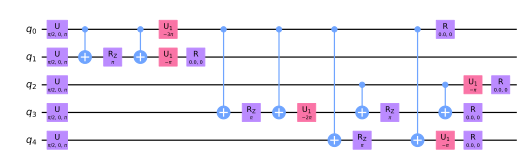

In [164]:
qaoa.draw(scale=0.6)

In [165]:
data

array([[0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

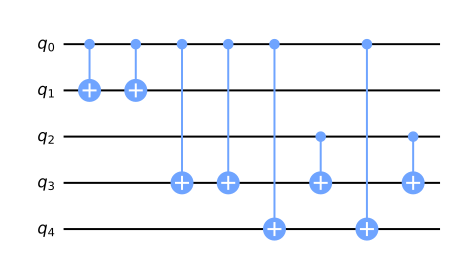

In [166]:
qc = QuantumCircuit(5)
qc.cx(0,1)
qc.cx(0,1)
qc.cx(0,3)
qc.cx(0,3)
qc.cx(0,4)
qc.cx(0,4)
qc.cx(2,3)
qc.cx(2,3)

qc.draw()

In [167]:
from qiskit.converters import circuit_to_dag
qaoa.draw()
dag = circuit_to_dag(qc)

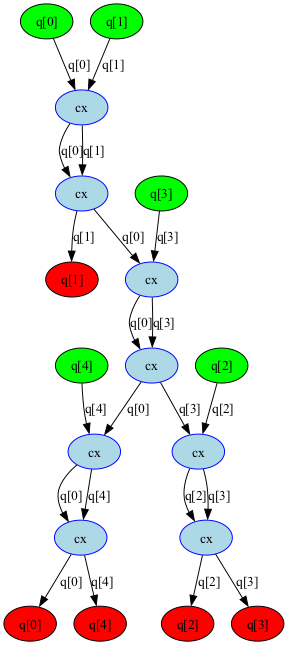

In [168]:
dag.draw()

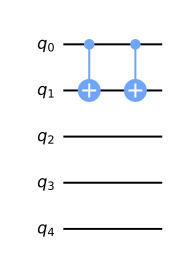

In [181]:
qc1 = QuantumCircuit(5)
qc1.cx(0,1)
qc1.cx(0,1)
qc1.draw()

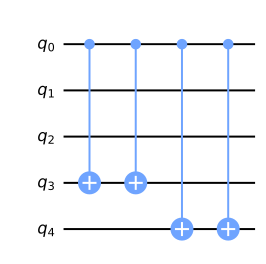

In [180]:
qc2 = QuantumCircuit(5)
qc2.cx(0,3)
qc2.cx(0,3)
qc2.cx(0,4)
qc2.cx(0,4)
qc2.draw()

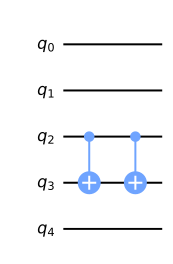

In [179]:
qc3 = QuantumCircuit(5)
qc3.cx(2,3)
qc3.cx(2,3)
qc3.draw()

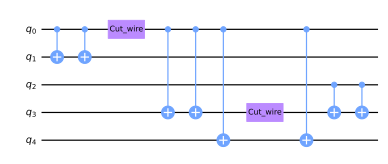

In [197]:
qc = QuantumCircuit(5)
qc_0= qc.compose(qc1)

qc_0.append(CutWire(), [0])

qc_1= qc_0.compose(qc2)

qc_1.append(CutWire(), [3])

qc_2 = qc_1.compose(qc3)

qc_2.draw(scale=0.6)

In [89]:
'''qubit_sc_idx = {}
all_sc_idx = []
for k, i in cuts['complete_path_map'].items():
    #print(k.index)
    qubit_sc_idx.setdefault(k.index,[])
    for m in range(len(i)):
        #print((f"suncircuit idx= :{i[m]['subcircuit_idx']}"))
        qubit_sc_idx[k.index].append(i[m]['subcircuit_idx'])
        all_sc_idx.append(i[m]['subcircuit_idx'])'''

'qubit_sc_idx = {}\nall_sc_idx = []\nfor k, i in cuts[\'complete_path_map\'].items():\n    #print(k.index)\n    qubit_sc_idx.setdefault(k.index,[])\n    for m in range(len(i)):\n        #print((f"suncircuit idx= :{i[m][\'subcircuit_idx\']}"))\n        qubit_sc_idx[k.index].append(i[m][\'subcircuit_idx\'])\n        all_sc_idx.append(i[m][\'subcircuit_idx\'])'

In [53]:
data

array([[0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [103]:
set([v for i in qubit_sc_idx.values() for v in i ])

{0, 1, 2}

In [98]:
sc_idx_

{0: [0, 1], 1: [0, 3, 4], 2: [2, 3]}

In [102]:
data[sc_idx_[0],sc_idx_[0]]

array([0., 0.])

In [103]:
data[sc_idx_[1],sc_idx_[1]]

array([0., 0., 0.])

In [124]:
data

array([[0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [126]:
data[[2,3],:][:,[2,3]]

array([[0., 1.],
       [1., 0.]])

In [128]:
data[[0,3,4],:][:,[0,3,4]]

array([[0., 1., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [129]:
data[[0,1],:][:,[0,1]]

array([[0., 1.],
       [1., 0.]])

In [134]:
idx= sc_idx_[0]

In [138]:
idx

[0, 1]

In [140]:
data[sc_idx_[0],:][:,sc_idx_[0]]

array([[0., 1.],
       [1., 0.]])

In [141]:
### construct qaoa for each of the sub-circuits

In [ ]:
#create matrix with all elements, 0 for the keys not in sc_idx_
#create qaoa for the entire matrix
# apply cut
# compose the next qaoa - since all mtrices are of same shape, the circuit will be applied on the right qubits

In [144]:
len(qubit_sc_idx)

5

In [145]:
d = np.zeros(shape=(len(qubit_sc_idx),len(qubit_sc_idx)))

In [147]:
d[sc_idx_[0],:][:,sc_idx_[0]] = data[sc_idx_[0],:][:,sc_idx_[0]]

In [153]:
sc_idx_[0]

[0, 1]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [154]:
d = data

In [161]:
d

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [165]:
d[:,0]=0 
d

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [196]:
d[:,0]= 0

In [198]:
d[0,:]=0

In [199]:
d

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [176]:
sc_idx_

{0: [0, 1], 1: [0, 3, 4], 2: [2, 3]}

In [204]:
qaoa_d = []
for k, v in sc_idx_.items():
    #print(k)
    print(v)
    d = data.copy()
    for i in qubit_sc_idx.keys():
        if i not in v:
        #    print(d[i])
            d[:,i]=0
            d[i,:]=0
    print(d)
    qaoa_d.append(d)

[0, 1]
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[0, 3, 4]
[[0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[2, 3]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [205]:
qaoa_d

[array([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.]])]

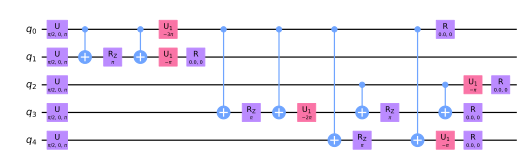

In [826]:
qaoa.draw(scale=0.6)

In [92]:
qc = QuantumCircuit(len(qubit_sc_idx.keys()))

def build_cut_wire_circuit(qc, qaoa_sc, cut_pos):
    for idx, q in enumerate(qaoa_sc):
        qp1 = create_qp_from_qmatrix(q)
        print(qp1)
        h_qubo1, offset1, qaoa1 = create_qaoa_ansatz(qp1)
        print(h_qubo1)
        qc = qc.compose(qaoa1)

        #check if the sub-circuit idx in the cut pos
        for qubit_idx, subcircuit_idx in cut_pos.items():
            print(subcircuit_idx)
            if idx in subcircuit_idx:
                print('here')
                qc.append(CutWire(), [qubit_idx])
    return qc

qc_0 = build_cut_wire_circuit(qc, qaoa_sc, cut_pos)

minimize 2*x1*x2 (5 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IIIZZ
- 0.5 * IIIIZ
- 0.5 * IIIZI
[0]
here
[1]
minimize 2*x1*x4 + 2*x1*x5 (5 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IZIIZ
- 1.0 * IIIIZ
- 0.5 * IZIII
+ 0.5 * ZIIIZ
- 0.5 * ZIIII
[0]
[1]
here
minimize 2*x3*x4 (5 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IZZII
- 0.5 * IIZII
- 0.5 * IZIII
[0]
[1]


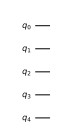

In [334]:
qc = QuantumCircuit(len(qubit_sc_idx.keys()))
qc.draw(scale=0.5)

In [335]:
qp1 = create_qp_from_qmatrix(qaoa_d[0])
print(qp1)
h_qubo1, offset1, qaoa1 = create_qaoa_ansatz(qp1)
print(h_qubo1)
qc_0 = qc.compose(qaoa1)
qc_0.append(CutWire(), [0])
 

qp2 = create_qp_from_qmatrix(qaoa_d[1])
print(qp2)
h_qubo2, offset2, qaoa2 = create_qaoa_ansatz(qp2)
print(h_qubo2)
qc_0 = qc_0.compose(qaoa2)
#qc_0.append(CutWire(), [3])

qp3 = create_qp_from_qmatrix(qaoa_d[2])
print(qp3)
h_qubo3, offset3, qaoa3 = create_qaoa_ansatz(qp3)
print(h_qubo3)
qc_0 = qc_0.compose(qaoa3)
qc_0.append(CutWire(), [0])


minimize 2*x1*x2 (5 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IIIZZ
- 0.5 * IIIIZ
- 0.5 * IIIZI
minimize 2*x1*x4 + 2*x1*x5 (5 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IZIIZ
- 1.0 * IIIIZ
- 0.5 * IZIII
+ 0.5 * ZIIIZ
- 0.5 * ZIIII
minimize 2*x3*x4 (5 variables, 0 constraints, 'QUBO Matrix Optimization')
0.5 * IZZII
- 0.5 * IIZII
- 0.5 * IZIII


In [337]:
'''for i in range(len(qaoa_d)):
    qp = create_qp_from_qmatrix(qaoa_d[i])
    print(qp)
    h_qubo, offset, qaoa = create_qaoa_ansatz(qp)
    print(h_qubo)
    qc = qc.compose(qaoa)
    qc.append(CutWire(), [0])
    qaoa    '''

'for i in range(len(qaoa_d)):\n    qp = create_qp_from_qmatrix(qaoa_d[i])\n    print(qp)\n    h_qubo, offset, qaoa = create_qaoa_ansatz(qp)\n    print(h_qubo)\n    qc = qc.compose(qaoa)\n    qc.append(CutWire(), [0])\n    qaoa    '

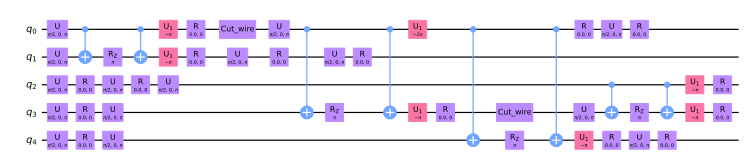

In [93]:
qc_0.draw(scale=0.6)

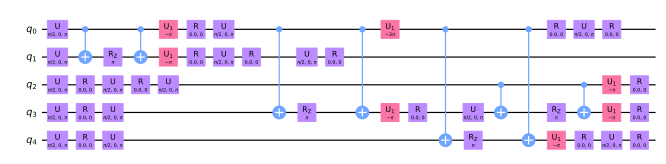

In [94]:
qc_0.decompose("cut_wire").draw("mpl", scale=0.6)

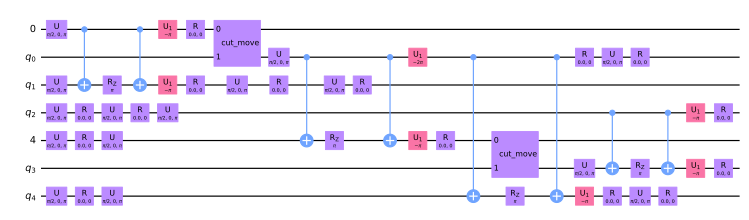

In [95]:
qc_1 = cut_wires(qc_0)
qc_1.draw("mpl", scale=0.6)

In [340]:
observables

PauliList(['IIIZZ', 'IIIIZ', 'IIIZI', 'IZIIZ', 'IZIII', 'IZZII', 'IIZII',
           'ZIIIZ', 'ZIIII'])

In [341]:
observables_1 = expand_observables(observables, qc_0, qc_1)
observables_1

PauliList(['IIIZZII', 'IIIIZII', 'IIIZIII', 'IZIIZII', 'IZIIIII',
           'IZZIIII', 'IIZIIII', 'ZIIIZII', 'ZIIIIII'])

In [342]:
partitioned_problem = partition_problem(circuit=qc_1, observables=observables_1)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

In [198]:
bases = partitioned_problem.bases
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 256.0


In [ ]:
#### run some experiments for diff sizes and plot the sampling overhead - 
#compare sampling overhead for partition vs cut wire --- consolidate sc, mc, kmeans, cutqc, partitioning

In [ ]:
#1. classical cost - cplex in cutqc
# reason for moving away from cplex?
# best way to reduce sampling overhead
# how to use the sampling estimation info to decide on # of sub-expermients
# what is the best way to compare the outcomes of diff paritioning strategy? exp val or prob dist or sampling cost?

In [343]:
'''partitioned_problem = partition_problem(circuit=qc_0, observables=observables)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables'''

'partitioned_problem = partition_problem(circuit=qc_0, observables=observables)\nsubcircuits = partitioned_problem.subcircuits\nsubobservables = partitioned_problem.subobservables'

In [344]:
subobservables

{0: PauliList(['ZI', 'II', 'ZI', 'II', 'II', 'II', 'II', 'II', 'II']),
 1: PauliList(['IIII', 'IIII', 'IIII', 'IZII', 'IZII', 'IZZI', 'IIZI',
            'ZIII', 'ZIII']),
 2: PauliList(['Z', 'Z', 'I', 'Z', 'I', 'I', 'I', 'Z', 'I'])}

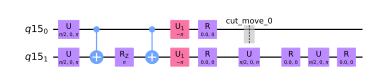

In [345]:
subcircuits[0].draw("mpl", scale=0.6)

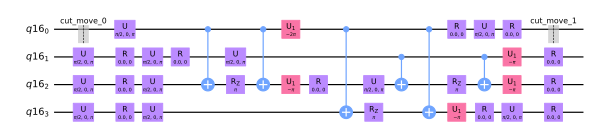

In [346]:
subcircuits[1].draw("mpl", scale=0.6)

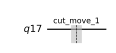

In [347]:
subcircuits[2].draw("mpl", scale=0.6)

In [348]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

In [349]:
sampler = Sampler(options={"shots": 2**12})
results = {
    label: sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}

QiskitError: 'Some classical bits are not used for measurements. the number of classical bits (2), the used classical bits ({1}).'

In [ ]:
#print(results[0])
#compare the similarity between the pd of original circuit and reconstructed circuits

print(results[0].quasi_dists)
plot_histogram(results[0].quasi_dists[0])

In [309]:
from qiskit_aer import AerSimulator

In [315]:
backend_sim = Aer.get_backend('aer_simulator')

In [289]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

ValueError: The num_qpd_bits field must be set in each subexperiment result metadata dictionary.

In [ ]:
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([qc_0] * len(observables_0), list(observables_0)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

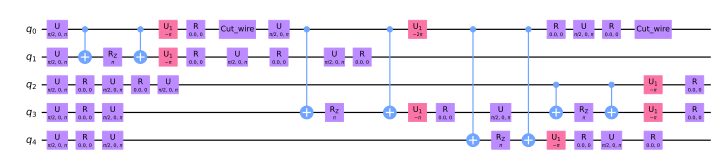

In [336]:
qc_0.draw(scale=0.6)

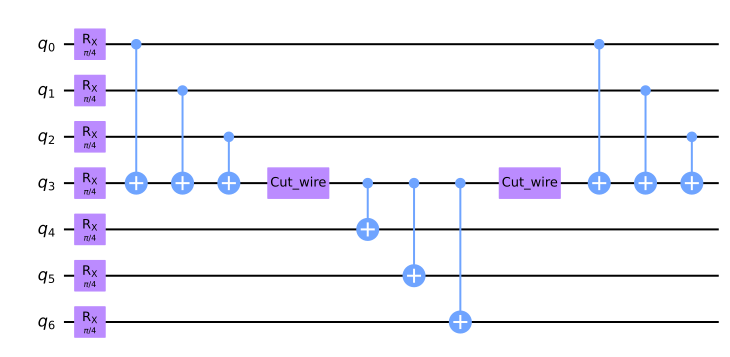

In [830]:
qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.append(CutWire(), [3])
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.append(CutWire(), [3])
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.draw("mpl")


In [842]:
observables_0 = PauliList(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

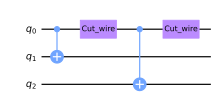

In [809]:
qc_0 = QuantumCircuit(3)
#for i in range(5):
#    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 1)
#qc_0.rz(np.pi , 1)
#qc_0.cx(0, 1)


#qc_0.cx(0, 2)
#qc_0.rz(np.pi , 3)
#qc_0.cx(0, 3)

qc_0.append(CutWire(), [0])

qc_0.cx(0, 2)
#qc_0.rz(np.pi , 4)
#qc_0.cx(0, 4)

qc_0.append(CutWire(), [0])

#qc_0.cx(2, )
#qc_0.rz(np.pi , 3)
#qc_0.cx(2, 3)
#qc_0.append(CutWire(), [0])


qc_0.draw(scale=0.6)



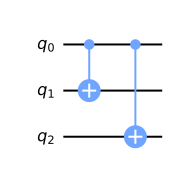

In [810]:
qc_0.decompose("cut_wire").draw("mpl")


In [811]:
h_qubit

PauliSumOp(SparsePauliOp(['IIIZZ', 'IIIIZ', 'IIIZI', 'IZIIZ', 'IZIII', 'IZZII', 'IIZII', 'ZIIIZ', 'ZIIII'],
              coeffs=[ 0.5+0.j, -1.5+0.j, -0.5+0.j,  0.5+0.j, -1. +0.j,  0.5+0.j, -0.5+0.j,
  0.5+0.j, -0.5+0.j]), coeff=1.0)

In [812]:
observables_0 = PauliList(['IIZ'])#, 'IZZ'])#, 'IIIZI', 'IZIIZ'])#, 'IZIII', 'IZZII', 'IIZII', 'ZIIIZ', 'ZIIII'])
#observables_0 = PauliList(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

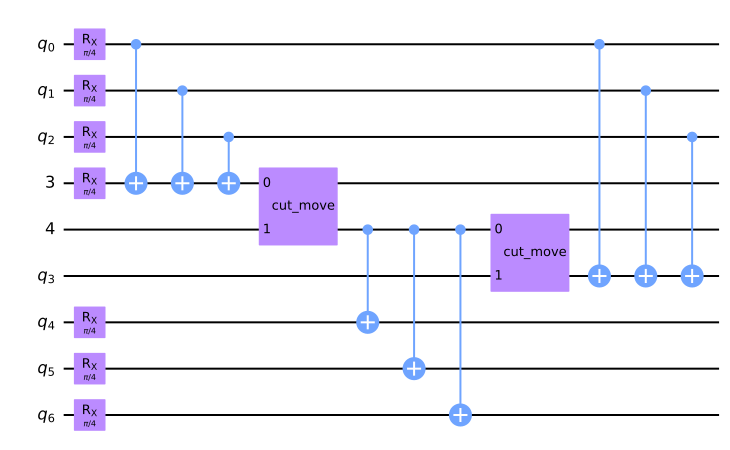

In [833]:
qc_1 = cut_wires(qc_0)
qc_1.draw("mpl")

In [843]:
observables_1 = expand_observables(observables_0, qc_0, qc_1)
observables_1

PauliList(['ZIIIIIIII', 'IIIZIIIII', 'IIIIIIIIZ'])

In [844]:
partitioned_problem = partition_problem(circuit=qc_1, observables=observables_1)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables


In [845]:
subobservables

{0: PauliList(['IIIII', 'ZIIII', 'IIIIZ']),
 1: PauliList(['ZIII', 'IIII', 'IIII'])}

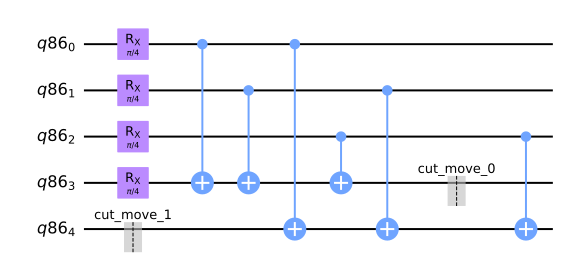

In [846]:
subcircuits[0].draw()

In [847]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=1,
)

In [848]:
subexperiments

{0: [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fea032012d0>],
 1: [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fea03201d20>]}

In [849]:
for i, values in subexperiments.items():
    for j in values:
        print(j)
    print('next')

                           ┌─────────┐                              ┌─┐        
                    q86_0: ┤ Rx(π/4) ├──■──────────────■────────────┤M├────────
                           ├─────────┤  │              │            └╥┘        
                    q86_1: ┤ Rx(π/4) ├──┼────■─────────┼─────────■───╫─────────
                           ├─────────┤  │    │         │         │   ║         
                    q86_2: ┤ Rx(π/4) ├──┼────┼────■────┼─────────┼───╫───■─────
                           ├─────────┤┌─┴─┐┌─┴─┐┌─┴─┐  │         │   ║   │     
                    q86_3: ┤ Rx(π/4) ├┤ X ├┤ X ├┤ X ├──┼───|0>───┼───╫───┼─────
                           └─────────┘├───┤├───┤└───┘┌─┴─┐     ┌─┴─┐ ║ ┌─┴─┐┌─┐
                    q86_4: ────|0>────┤ X ├┤ H ├─────┤ X ├─────┤ X ├─╫─┤ X ├┤M├
                                      └───┘└───┘     └───┘     └───┘ ║ └───┘└╥┘
observable_measurements: 2/══════════════════════════════════════════╩═══════╩═
                                        

In [821]:
#subexperiments[1][3].draw()

In [822]:
#subexperiments[0][5].draw()

In [823]:
#subexperiments[3][4].draw()

In [824]:
coefficients

[(-16.0, <WeightType.SAMPLED: 2>)]

In [850]:
for label, subexperiment in subexperiments.items():
        print(label)
        #if label==0:
        #    continue
        #print(subexperiment[0])
        result = {label: sampler.run(subexperiment).result()}
        print(result)

0
{0: SamplerResult(quasi_dists=[{0: 0.467529296875, 1: 0.038818359375, 2: 0.455810546875, 3: 0.037841796875}], metadata=[{'shots': 4096}])}
1


QiskitError: 'Some classical bits are not used for measurements. the number of classical bits (2), the used classical bits ({1}).'

In [741]:
sampler = Sampler(options={"shots": 2**12})
results = {
    label: sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}


QiskitError: 'Some classical bits are not used for measurements. the number of classical bits (1), the used classical bits (set()).'

In [739]:
result

{2: SamplerResult(quasi_dists=[{0: 0.49365234375, 1: 0.50634765625}], metadata=[{'shots': 4096}])}

In [670]:
reconstructed_expvals = reconstruct_expectation_values(
    result,
    coefficients,
    subobservables,
)

KeyError: 0

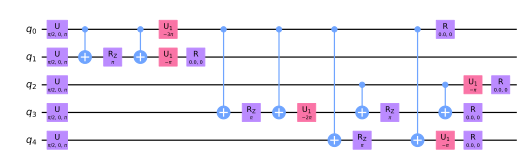

In [829]:
qaoa.draw(scale=0.6)

#### exp with example -- variations

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables

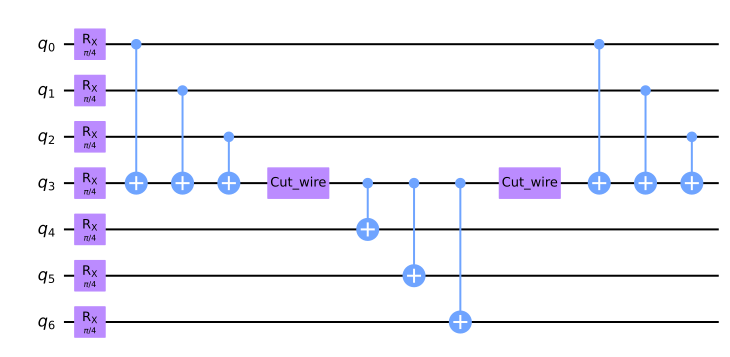

In [23]:
qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.append(CutWire(), [3])
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.append(CutWire(), [3])
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.draw("mpl")

In [24]:
#qc_0.decompose("cut_wire").draw("mpl")

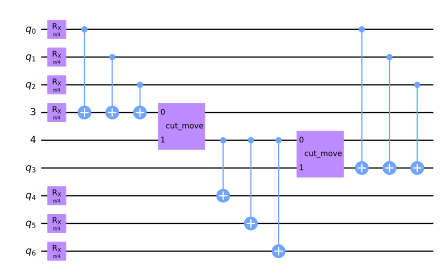

In [25]:
qc_1 = cut_wires(qc_0)
qc_1.draw("mpl", scale=0.6)

In [26]:
observables_0 = PauliList(["ZIIIIII", "IIIZIII"])

In [27]:
observables_1 = expand_observables(observables_0, qc_0, qc_1)
observables_1

PauliList(['ZIIIIIIII', 'IIIZIIIII'])

In [28]:
partitioned_problem = partition_problem(circuit=qc_1, observables=observables_1)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

In [29]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=1,
)

In [35]:
subexperiments

{0: [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fee0901d570>],
 1: [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fee08f65f30>]}

In [30]:
for i, values in subexperiments.items():
    for j in values:
        print(j)
    print('next')

                           ┌─────────┐                                     »
                    q31_0: ┤ Rx(π/4) ├──■──────────────■───────────────────»
                           ├─────────┤  │              │                   »
                    q31_1: ┤ Rx(π/4) ├──┼────■─────────┼───────────■───────»
                           ├─────────┤  │    │         │           │       »
                    q31_2: ┤ Rx(π/4) ├──┼────┼────■────┼───────────┼───────»
                           ├─────────┤┌─┴─┐┌─┴─┐┌─┴─┐  │  ┌─────┐  │  ┌───┐»
                    q31_3: ┤ Rx(π/4) ├┤ X ├┤ X ├┤ X ├──┼──┤ Sdg ├──┼──┤ H ├»
                           └─────────┘├───┤├───┤└───┘┌─┴─┐└─────┘┌─┴─┐└───┘»
                    q31_4: ────|0>────┤ X ├┤ H ├─────┤ X ├───────┤ X ├─────»
                                      └───┘└───┘     └───┘       └───┘     »
       qpd_measurements: 1/════════════════════════════════════════════════»
                                                                           »

In [31]:
sampler = Sampler(run_options={"shots": 500})

In [32]:
for label, subexperiment in subexperiments.items():
        print(label)
        #if label==0:
        #    continue
        #print(subexperiment[0])
        result = {label: sampler.run(subexperiment).result()}
        print(result)

0
{0: SamplerResult(quasi_dists=[{1: 0.284, 2: 0.158, 3: 0.354, 0: 0.204}], metadata=[{'shots': 500, 'simulator_metadata': {'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.000234754, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1, 2, 3, 4], 'measure_sampling': True, 'num_clbits': 2, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]], 'num_qubits': 5, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}])}
1
{1: SamplerResult(quasi_dists=[{1: 0.23, 3: 0.274, 2: 0.25, 0: 0.246}], metadata=[{'shots': 500, 'simulator_metadata': {'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.000171623, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1, 2, 3], 'measure_sampling': True, 'num_clbits': 2, 'input_qubit_map': [[0, 0], [

In [33]:
sampler = Sampler(run_options={"shots": 2**12})
results = {
    label: sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}

In [34]:
results

{0: SamplerResult(quasi_dists=[{1: 0.308837890625, 0: 0.19580078125, 2: 0.191650390625, 3: 0.3037109375}], metadata=[{'shots': 4096, 'simulator_metadata': {'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.001787304, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1, 2, 3, 4], 'measure_sampling': True, 'num_clbits': 2, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]], 'num_qubits': 5, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}]),
 1: SamplerResult(quasi_dists=[{1: 0.25146484375, 2: 0.251220703125, 3: 0.252685546875, 0: 0.24462890625}], metadata=[{'shots': 4096, 'simulator_metadata': {'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.001227476, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1, 2, 3], 'meas

In [16]:
print(results[0])

SamplerResult(quasi_dists=[{1: 0.3837890625, 0: 0.6162109375}], metadata=[{'shots': 4096, 'simulator_metadata': {'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.001381814, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1, 2, 3], 'measure_sampling': True, 'num_clbits': 1, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3]], 'num_qubits': 4, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}])


In [17]:
print(results[1])

SamplerResult(quasi_dists=[{1: 0.075439453125, 3: 0.4267578125, 2: 0.428955078125, 0: 0.06884765625}], metadata=[{'shots': 4096, 'simulator_metadata': {'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.001533448, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0, 1, 2, 3], 'measure_sampling': True, 'num_clbits': 2, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3]], 'num_qubits': 4, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}])


In [18]:
print(results[2])

SamplerResult(quasi_dists=[{1: 0.51171875, 0: 0.48828125}], metadata=[{'shots': 4096, 'simulator_metadata': {'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.000874349, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0], 'measure_sampling': True, 'num_clbits': 1, 'input_qubit_map': [[0, 0]], 'num_qubits': 1, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}])


In [20]:
subobservables

{0: PauliList(['IIII', 'IIII']),
 1: PauliList(['ZIII', 'IIII']),
 2: PauliList(['I', 'Z'])}

In [21]:
reconstructed_expvals = reconstruct_expectation_values(
    results[0],
    coefficients[0],
    subobservables[0],
)

ValueError: The num_qpd_bits field must be set in each subexperiment result metadata dictionary.

### rustworkx

In [154]:
import rustworkx as rx

In [149]:
from rustworkx import stoer_wagner_min_cut

In [155]:
pg = rx.PyGraph.from_adjacency_matrix(data)

In [196]:
stoer_wagner_min_cut(pg)

(1.0, <rustworkx.NodeIndices at 0x7fede9b24fc0>)

In [195]:
s.index

<function tuple.index(value, start=0, stop=9223372036854775807, /)>